# Import a bunch

In [ ]:
!pip install pydub
#!pip install librosa==0.8.0

In [ ]:
# Import a bunch
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.image as mpimg
import seaborn as sns
import os
from glob import glob
import shutil
import pathlib
import random
import pickle
from IPython.display import Audio
import pydub

# Model
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend 
from tensorflow.keras import initializers
import tensorflow as tf
print(tf.__version__)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract data

In [ ]:
# Install kaggle
! pip install -q kaggle
#Upload json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datnguyn","key":"69c14f649dd7364914db7810156aeea6"}'}

In [ ]:
# Download dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mozillaorg/common-voice
! kaggle datasets download -d chrisfilo/urbansound8k

100% 12.0G/12.0G [04:52<00:00, 45.9MB/s]
100% 12.0G/12.0G [04:52<00:00, 44.1MB/s]
100% 5.61G/5.61G [02:27<00:00, 48.4MB/s]
100% 5.61G/5.61G [02:27<00:00, 40.7MB/s]


In [ ]:
# Extract dataset
# Common Voice
%mkdir /content/common_voice
%cd /content/common_voice
!unzip /content/common-voice.zip && rm /content/common-voice.zip
# Urban Sound
%mkdir /content/urban_sound
%cd /content/urban_sound
!unzip /content/urbansound8k.zip && rm /content/urbansound8k.zip

#Return to main directory
%cd /content/

# Functions definition

In [ ]:
#Utils

# Convert from .mp3 files to .wav files
def convert_to_wav(path, destination_path):
  filenames = os.path.split(path)[-1]
  # convert wav to mp3                                                            
  sound = pydub.AudioSegment.from_mp3(path)
  sound.export(os.path.join(destination_path, str(filenames[:-4]+'.wav')), format="wav")
  os.remove(path)
# Read .wav files
def read_wav(path, sr=8000):
  signal, sr = librosa.load(path, sr=8000, mono=True)
  return signal
# Trim silence audio
#def trim_audio(audio):
#  signal, sr = librosa.effects.trim(audio, top_db=10)
#  return signal
# Combine clean audio and noisy audio
def get_noisy_audio(clean_audio, noise_signal):
  if len(clean_audio) >= len(noise_signal):
    while len(clean_audio) >= len(noise_signal):
        noise_signal = np.append(noise_signal, noise_signal)
  ## Extract a noise segment from a random location in the noise file
  ind = np.random.randint(0, noise_signal.size - clean_audio.size)
  noiseSegment = noise_signal[ind: ind + clean_audio.size]
  speech_power = np.sum(clean_audio ** 2)
  noise_power = np.sum(noiseSegment ** 2)
  noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
  return noisyAudio
# Extended short sound
#def extend_short_sounds(data, target_duration=24000):
#  stretched = librosa.effects.time_stretch(data, rate=data.shape[0]/target_duration)
#  return stretched[:target_duration:]

# Load pickle file
def load_data(pikcle_path):
  with open(pikcle_path, "rb") as fp: # opening for reading
    data = pickle.load(fp)
  # convert list into numpy arrays
  # inputs = np.array(data['train_data_noisy'])
  # targets = np.array(data['train_data'])
  return data
# Save data to pickle file
def save_pickle(pickle_path, data_dict):
  with open(pickle_path, "wb") as fp: # opening for reading
    pickle.dump(data_dict, fp)

In [ ]:
# Get spectrogram and STFT
def get_stft(signal, n_fft=255, hop_length=188):
    return librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, center=True)

def data_to_spec(signal):
    if signal.shape[0] > 24000:
      idx = np.random.randint(0, signal.shape[0] - 24000) #Slide the signal to 3s length
      signal = signal[idx: idx + 24000]
      stft = get_stft(signal)
      spec, phase = librosa.magphase(stft)
      spec = librosa.amplitude_to_db(spec, ref=np.max)
      return spec, phase
    elif signal.shape[0] < 24000: #Ignore short signal under 3s length
      pass

def file_to_spec(path):
    signal = read_wav(path)
    #if signal.shape[0] > 24000:
    #  idx = np.random.randint(0, signal.shape[0] - 24000) #Avoid keeping the silence audio at the beginning
    #  signal = signal[idx: idx + 24000]
    return data_to_spec(signal)
    #elif signal.shape[0] < 24000:
    #  pass

def get_audio_from_stft(stft_features):
    return librosa.griffinlim(stft_features)

def get_audio_from_spec(spectrogram, phase, hop_length=188, length=24000):
  D = librosa.db_to_amplitude(spectrogram, ref=1)
  D_re = D*phase
  audio_reconstruct = librosa.core.istft(D_re, hop_length=hop_length, length=length)
  return Audio(audio_reconstruct, rate=8000)
  

In [ ]:
# Get MFCC
def data_to_mfcc(data):
    return librosa.feature.mfcc(data) 

def file_to_mfcc(path):
    data, rate = librosa.load(path)
    if data.shape[0] != TARGET_LEN: # handle short sounds
        data = extend_short_sounds(data)
    return data_to_mfcc(data)

In [ ]:
#norm_value = 2 * data ./ (max_range_value - min_range_value);
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec


In [ ]:
# Prediction - Input preprocessing
def data_to_spec_auto_scale(audio_path):
    signal = read_wav(audio_path)
    frame_length = signal.shape[0]
    hop_length = math.floor(frame_length/127)
    stft = librosa.stft(signal, n_fft=255, hop_length=hop_length, center=True)
    if stft.shape[1] == 128:
      spec, phase = librosa.magphase(stft)
      spec = librosa.amplitude_to_db(spec, ref=np.max)
      return spec, phase, hop_length, frame_length
    else:
      hop_length = hop_length-1
      stft = librosa.stft(signal, n_fft=255, hop_length=hop_length, center=True)
      spec, phase = librosa.magphase(stft)
      spec = librosa.amplitude_to_db(spec, ref=1)
      return spec, phase, hop_length, frame_length   

# Prediction
def predict(audio_path):
    print(os.getcwd())
    model = keras.models.load_model('./model.h5')
    a, b, c, d = data_to_spec_auto_scale(audio_path)
    a = a[np.newaxis, ..., np.newaxis]
    m = model.predict(a)
    m_ou = a - m
    n_ou = np.squeeze(m_ou, (0, 3))
    n_ou = magnitude_db_and_phase_to_audio(n_ou, b, d, c)
    return n_ou

# Output preprocessing
def signal_to_audio(spec, phase, frame_length, hop_length_fft):
    """This functions reverts a spectrogram to an audio"""

    spec_to_amplitude = librosa.db_to_amplitude(spec, ref=1.0)

    # taking magnitude and phase of audio
    denoised_signal = spec_to_amplitude * phase
    denoised_audio = librosa.core.istft(denoised_signal, hop_length=hop_length_fft, length=frame_length)

    return Audio(denoised_audio, rate=8000)

# Preparing STFT Dataset

In [ ]:
# Getting list of mp3 files
mp3_data_path = pathlib.Path('/content/common_voice/cv-valid-train/cv-valid-train')
mp3_audio_paths = [os.path.join(mp3_data_path, name) for name in os.listdir(mp3_data_path) if os.path.isfile(os.path.join(mp3_data_path, name))]
len(mp3_audio_paths)

195776

In [ ]:
#Remore redundant directories

#shutil.rmtree('/content/common_voice/cv-other-dev')
#shutil.rmtree('/content/common_voice/cv-invalid')
#shutil.rmtree('/content/common_voice/cv-other-test')
#shutil.rmtree('/content/common_voice/cv-other-train')
#shutil.rmtree('/content/common_voice/cv-valid-dev')
#shutil.rmtree('/content/common_voice/cv-valid-test')
#shutil.rmtree('/content/clean')
#random.shuffle(mp3_audio_paths)
#shutil.rmtree('/content/common_voice')
#shutil.rmtree('/content/urban_sound')

In [ ]:
# Converting Common Voice .mp3 files to .wav
dest = '/content/clean'
for i in range(10001,15001):
  count = 0
  try:
    if i % 500 ==0:
      print('processed {}'.format(i))
    convert_to_wav(mp3_audio_paths[i], dest)
  except:
    count +=1
    pass

In [ ]:
# New .wav files
data_path = pathlib.Path('/content/clean')
all_train_paths = [os.path.join(data_path, name) for name in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, name))]
len(all_train_paths)

15000

In [ ]:
# Move all noise files into one folder
src_noise_files = glob(os.path.join('/content/urban_sound', '*', '*.wav'))
noise_dir = pathlib.Path('/content/noises')
for wav_file in src_noise_files:
  shutil.move((wav_file),(noise_dir))

# Getting list of noise files
all_noise_path = glob(os.path.join(noise_dir, '*.wav'))
len(all_noise_path)

8732

In [ ]:
# Shuffle the list of files
random.shuffle(all_train_paths)
random.shuffle(all_noise_path)

In [ ]:
# Get signal of audio and noisy audio
train_audio = []
train_audio_noisy = []
count = 0
count_success = 0
for path in all_train_paths:
  
  clean_signal = read_wav(path)
  noise_file = random.choice(all_noise_path)
  noise_audio = read_wav(noise_file)
  noisy_signal = get_noisy_audio(clean_signal, noise_audio)
  if clean_signal.shape[0] == noisy_signal.shape[0]:
    train_audio.append(clean_signal)
    train_audio_noisy.append(noisy_signal)
    count_success += 1
    if count_success % 100 == 0:
      print('Processed {}'.format(count_success))
    
  else:
    count += 1
print(count)

In [ ]:
# Get spectrogram of clean and noisy data
data={
    'clean_train_data': [],
    'noisy_train_data': []
}
for i in range(len(train_audio)):
  try:
    clean_spec, clean_phase = data_to_spec(train_audio[i])
    noisy_spec, noisy_phase = data_to_spec(train_audio_noisy[i])
    data['clean_train_data'].append(clean_spec)
    data['noisy_train_data'].append(noisy_spec)
  except:
    print('Skip file: {}'.format(i))
    pass

In [ ]:
# Save to pickle file for further uses
save_pickle('/content/drive/My Drive/train_audio.pkl', data['clean_train_data'])
save_pickle('/content/drive/My Drive/train_audio_noisy.pkl',data['noisy_train_data'])

In [ ]:
print('Available file for training: {} files'.format(len(data['clean_train_data'])))

Available file for training: 11618


In [ ]:
X = np.array(data['noisy_train_data'])
y = np.array(data['clean_train_data'])

In [ ]:
y_re = X-y

In [ ]:
X = X[..., np.newaxis]
y = y[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
X

(11618, 128, 128, 1)

# Training

In [ ]:
# Load data from pickle file
X = load_data('/content/drive/My Drive/data/full_noise.pkl')
y = load_data('/content/drive/My Drive/data/full_train.pkl')

In [ ]:
print('Available for train: {} files'.format(X.shape[0]))

Available for train: 48082 files


In [ ]:
#Define UNet
def unet(pretrained_weights = None,input_size = (128,128,1)):
    size_filter_in = 16
    #kernel_init = 'glorot_uniform'
    #kernel_init = tf.keras.initializers.glorot_normal
    activation_layer = None 
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv8)
    conv8 = LeakyReLU()(conv8)
    
    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = tf.keras.initializers.HeNormal(),
                                        bias_initializer=tf.keras.initializers.zeros())(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=5e-6), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])

    return model

2.3.0


In [ ]:
#Creating checkpoints
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='new_model_{epoch}.h5',
    save_best_only = True,
    verbose=1)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience =30,restore_best_weights=True)

In [ ]:
# Define inputs and outputs
X_in = X
X_ou = y
X_ou = X_in - X_ou
X_in = scaled_in(X_in)
X_ou = scaled_ou(X_ou)

In [ ]:
#Reshape the inputs and outputs for training
X_in = X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.1, random_state=42)

In [ ]:
generator_nn=unet()
generator_nn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        leaky_re_lu[0][0]                
_______________________________________________________________________________________

# New Section 4.47

(11618, 128, 128, 1)
(11618, 128, 128, 1)
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_69 (LeakyReLU)      (None, 128, 128, 16) 0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 16) 2320        leaky_re_lu_69[0][0]             
_____________________________________________

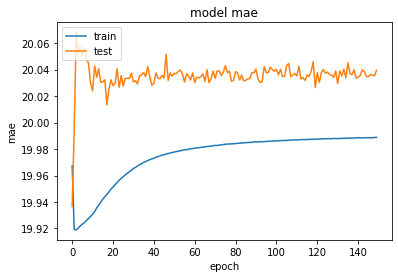

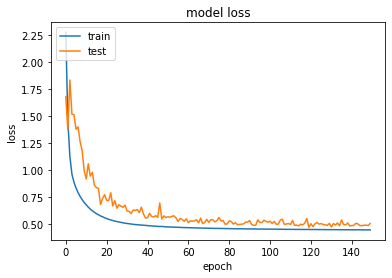

In [ ]:
history = generator_nn.fit(X_in, X_ou, epochs=100, 
                               batch_size=32, 
                               shuffle=True, 
                               callbacks=[checkpoint_cb,early_stopping_cb], 
                               verbose=1, 
                               validation_data=(X_test, y_test))

In [ ]:
#Save the best model
shutil.copy('/content/mymodel_120.h5', '/content/drive/My Drive/mymodel_120.h5')

'/content/drive/My Drive/mymodel_50.h5'